# Plot cover image

In [1]:
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from common import CURRENT_DUMP_FILENAME, get_data_directory, label_groups
from tqdm.notebook import tqdm

from allisbns.dataset import (
    CodeDataset,
    iterate_datasets,
    load_bencoded,
)
from allisbns.isbn import LAST_ISBN, TOTAL_ISBNS
from allisbns.plotting import BlockBinnedPlotter, get_default_colormap
from allisbns.rearrange import rearrange_to_blocks


%load_ext autoreload
%autoreload 2

## Load data

In [2]:
input_path = get_data_directory() / CURRENT_DUMP_FILENAME
input_path.name

'aa_isbn13_codes_20251222T170326Z.benc.zst'

In [3]:
with open(input_path, "rb") as f:
    input_data = load_bencoded(f)

In [4]:
collections = [x.decode() for x in input_data]
print(collections)

['airitibooks', 'bloomsbury', 'cadal_ssno', 'cerlalc', 'chinese_architecture', 'duxiu_ssid', 'edsebk', 'gbooks', 'goodreads', 'hathi', 'huawen_library', 'ia', 'isbndb', 'isbngrp', 'kulturpass', 'libby', 'md5', 'motw', 'nexusstc', 'nexusstc_download', 'oclc', 'ol', 'ptpress', 'rgb', 'sciencereading', 'shukui', 'sklib', 'trantor', 'wanfang', 'zjjd']


In [5]:
dataset_iterator = iterate_datasets(input_data, fill_to_isbn=LAST_ISBN)

first = next(dataset_iterator)
_, *collections_to_merge = collections

with tqdm(total=len(collections_to_merge)) as progress:
    merged_packed_bits = np.packbits(first.unpack_codes())
    for collection, dataset in zip(collections_to_merge, dataset_iterator, strict=True):
        progress.set_description(f"Merging with '{collection}'")
        np.bitwise_or(
            merged_packed_bits,
            np.packbits(dataset.unpack_codes()),
            out=merged_packed_bits,
        )
        progress.update()

all_merged = CodeDataset.from_unpacked(np.unpackbits(merged_packed_bits)[:TOTAL_ISBNS])
all_merged

  0%|          | 0/29 [00:00<?, ?it/s]

CodeDataset(array([  141,     1,     2, ...,  2439,     1, 96764],
      shape=(49543746,), dtype=int32), bounds=(978000000000, 979999999999))

## Plot image

In [6]:
figure_size = (12, 12)

plotter_kwargs = {
    "block_width": int(1e5),
    "block_size": int(5e7),
    "aspect": 2,
}

### Create group underlay

In [7]:
all_binned = all_merged.bin(2000)
all_binned

BinnedArray(array([1588, 1318,  881, ...,    0,    0,    0],
      shape=(1000000,), dtype=int32), bin_size=2000)

In [8]:
group_labels = label_groups(all_binned.bins, all_binned.bin_size)
defined_group_mask = np.where(group_labels > 0, True, False)
defined_group_mask

array([ True,  True,  True, ..., False, False, False], shape=(1000000,))

In [9]:
defined_group_image = rearrange_to_blocks(
    defined_group_mask,
    all_binned.bin_size,
    plotter_kwargs["block_width"],
    plotter_kwargs["block_size"],
)
defined_group_image

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]], shape=(500, 2000))

### Plot all together

In [10]:
input_timestamp = str(input_path).split(".")[0].split("_")[-1]
timestamp_formatted = datetime.fromisoformat(input_timestamp).isoformat()
timestamp_formatted

'2025-12-22T17:03:26+00:00'

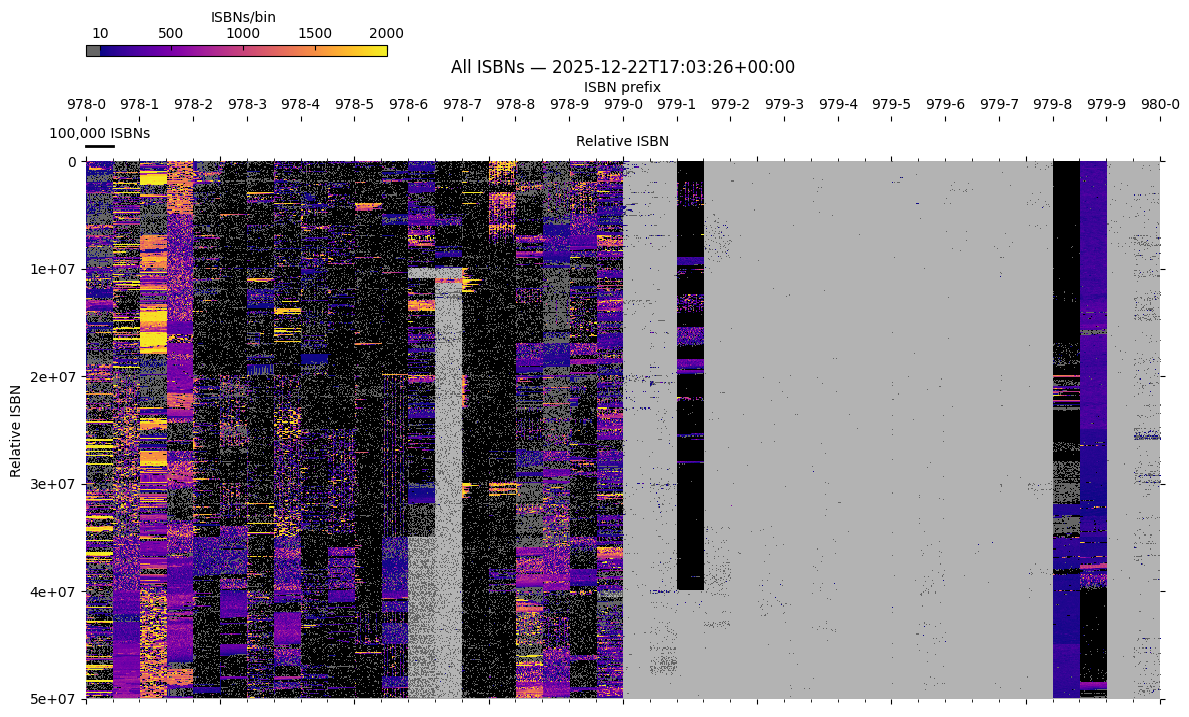

In [11]:
fig, ax = plt.subplots(figsize=figure_size)

plotter = BlockBinnedPlotter(ax, all_binned.bin_size, **plotter_kwargs)

plotter.plot_image(
    defined_group_image,
    colormap=mpl.colors.ListedColormap(["k"]),
    show_colorbar=False,
)

plotter.plot_bins(
    all_binned,
    vmin=10,
    colormap=get_default_colormap(nan_color="none", under_color="0.4"),
    colorbar_kwargs={"pad": 0.09},
)

ax.set_facecolor("0.7")

plt.title(f"All ISBNs — {timestamp_formatted}")

plt.savefig("../images/allisbns-cover-readme.jpg", bbox_inches="tight", dpi=100)

plt.tight_layout()
plt.show()

In [12]:
fig.savefig("../images/allisbns-cover-high.jpg", bbox_inches="tight", dpi=400)